In [1]:

import warnings, joblib, pathlib, numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
ARTIFACT_DIR = pathlib.Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)


In [4]:

df = sns.load_dataset("titanic")
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [6]:
display(df.describe(include='all'))

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891,891,891,203,889,891,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,7,3,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,C,Southampton,no,True
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644,491,537,537,59,644,549,537
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


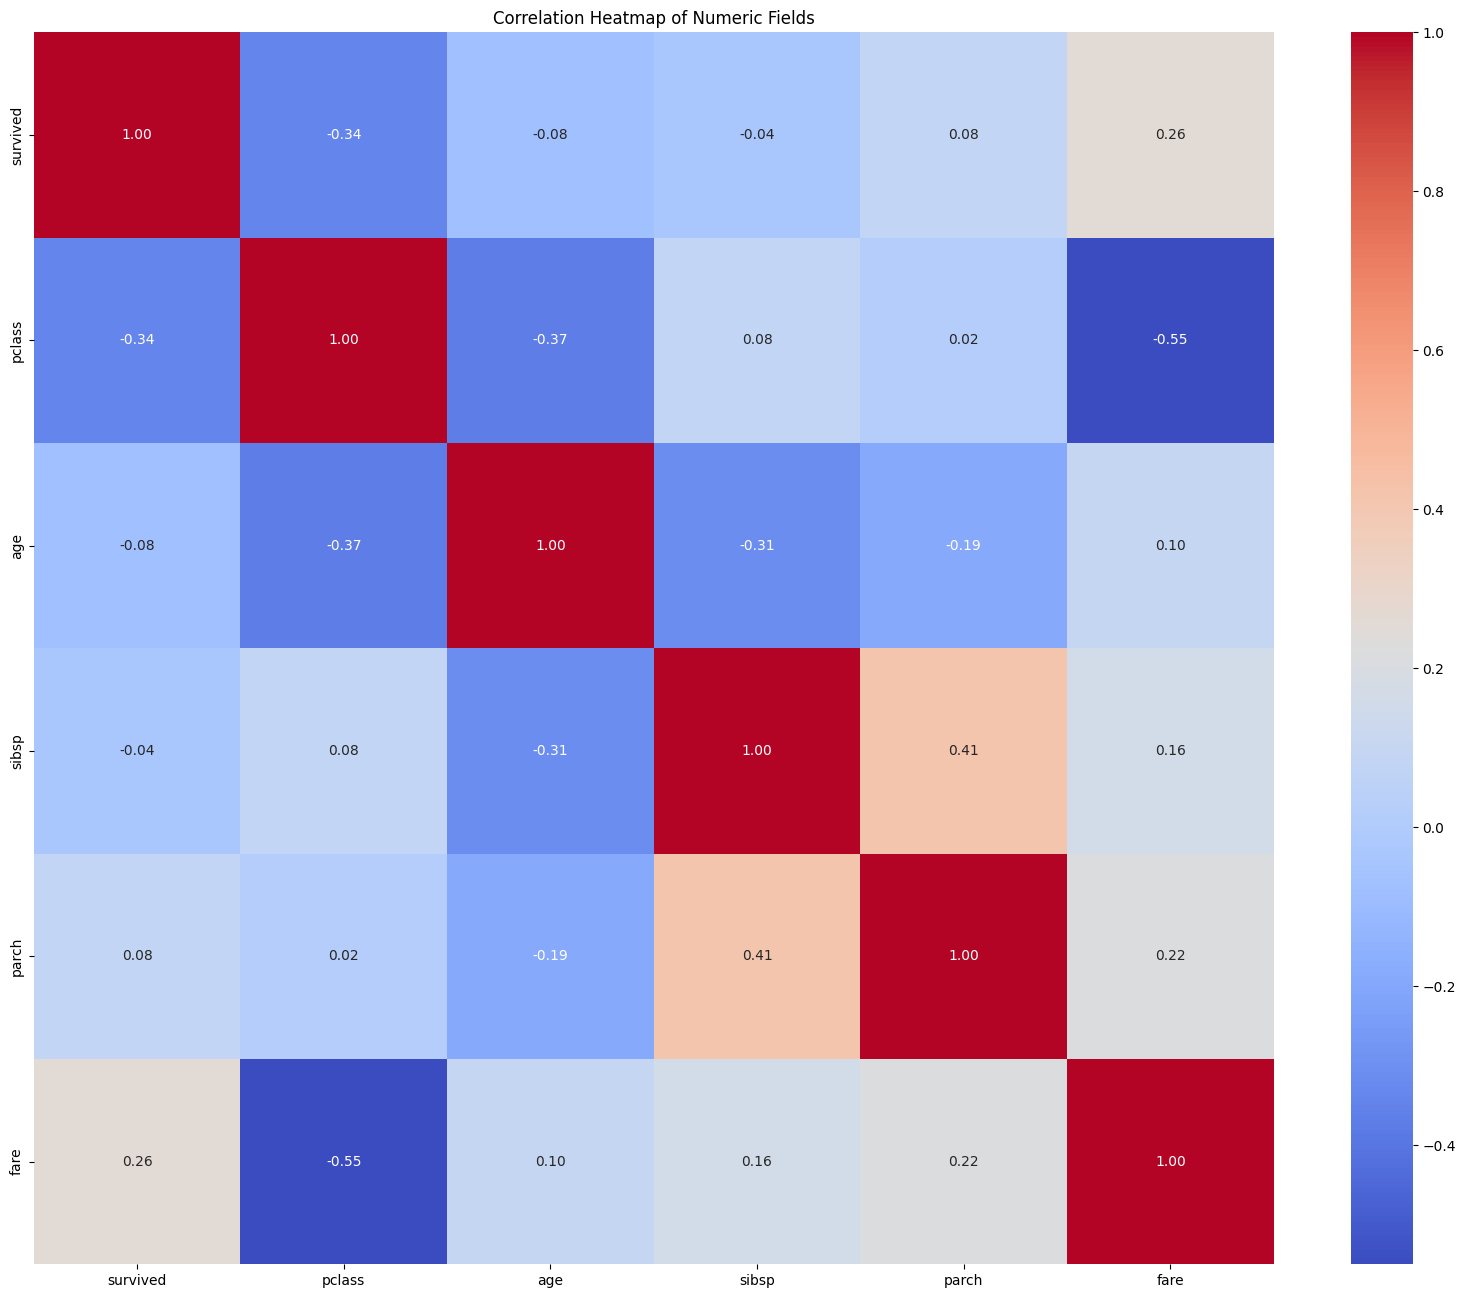

In [8]:
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Fields')
plt.show()


In [9]:

def engineer_features(X):
    """Create FamilySize, IsAlone and extract Title from Name."""
    X = X.copy()
    X["FamilySize"] = X["sibsp"] + X["parch"] + 1
    X["IsAlone"]    = (X["FamilySize"] == 1).astype(int)
    X["Title"] = X["who"].str.title().fillna("Unknown")
    fare_cap = X["fare"].quantile(0.99)
    X["fare"] = np.where(X["fare"] > fare_cap, fare_cap, X["fare"])
    X["fare_log1p"] = np.log1p(X["fare"])
    return X


In [10]:

def compute_vif(X_df):
    """Return VIF for each numeric column in X_df."""
    X_const = sm.add_constant(X_df.dropna())
    return pd.Series(
        [variance_inflation_factor(X_const.values, i)
         for i in range(X_const.shape[1])],
        index=X_const.columns, name="VIF"
    ).drop("const")


In [17]:
numeric_feats = ["age", "sibsp", "parch", "fare", "fare_log1p", "FamilySize"]
categorical_feats = ["sex", "embarked", "Title", "class", "adult_male", "deck", "IsAlone"]

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor now works on the output of engineer_features
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_feats),
    ("cat", categorical_pipe, categorical_feats)
])

full_pipe = Pipeline([
    ("feat_eng", FunctionTransformer(engineer_features, validate=False)),
    ("prep", preprocessor),
    ("clf",  LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

In [13]:

X = df.drop(columns=["survived"])
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

full_pipe.fit(X_train, y_train)
print("Training accuracy:", full_pipe.score(X_train, y_train))
print("Test accuracy:", full_pipe.score(X_test,  y_test ))


Training accuracy: 0.8370786516853933
Test accuracy: 0.8212290502793296


In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

high_corr = corr[corr > 0.75].index.tolist()
high_vif  = vif[vif > 5].index.tolist()
to_drop   = list(set(high_corr + [v for v in high_vif if v != 'FamilySize']))

print("Dropping redundant features:", to_drop)

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

pipe_sel = Pipeline([
    ("feat_eng", FunctionTransformer(engineer_features, validate=False)),
    ("drop_feats", DropColumns(columns_to_drop=to_drop)),
    ("prep", preprocessor),
    ("clf",  LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

remaining_numeric_feats = [f for f in numeric_feats if f not in to_drop]
remaining_categorical_feats = [f for f in categorical_feats if f not in to_drop]

updated_preprocessor = ColumnTransformer([
    ("num", numeric_pipe, remaining_numeric_feats),
    ("cat", categorical_pipe, remaining_categorical_feats)
])

pipe_sel = Pipeline([
    ("feat_eng", FunctionTransformer(engineer_features, validate=False)),
    ("drop_feats", DropColumns(columns_to_drop=to_drop)),
    ("prep", updated_preprocessor),
    ("clf",  LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])


pipe_sel.fit(X_train, y_train)
print("Selected-feature Test accuracy:",
      round(pipe_sel.score(X_test, y_test), 3))


Dropping redundant features: ['sibsp', 'parch']
Selected-feature Test accuracy: 0.821


In [29]:

X_train_sel = pipe_sel.named_steps['prep'].transform(pipe_sel.named_steps['drop_feats'].transform(pipe_sel.named_steps['feat_eng'].transform(X_train)))
X_test_sel = pipe_sel.named_steps['prep'].transform(pipe_sel.named_steps['drop_feats'].transform(pipe_sel.named_steps['feat_eng'].transform(X_test)))

ARTIFACT_DIR.mkdir(exist_ok=True)

joblib.dump(X_train_sel, ARTIFACT_DIR/"X_train.pkl")
joblib.dump(X_test_sel,  ARTIFACT_DIR/"X_test.pkl")
joblib.dump(y_train,     ARTIFACT_DIR/"y_train.pkl")
joblib.dump(y_test,      ARTIFACT_DIR/"y_test.pkl")
joblib.dump(pipe_sel,    ARTIFACT_DIR/"titanic_pipe.joblib")
print("Artifacts saved to", ARTIFACT_DIR.resolve())

Artifacts saved to /content/artifacts
